# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv 
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [1]:
# 1

import pandas as pd

car_df = pd.read_csv('./data/cars_hw.csv')

car_df.head()


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [2]:

# remove the 'Unnamed: 0' column
cars_data_cleaned = car_df.drop(columns=['Unnamed: 0'])

# check for duplicates
duplicates = cars_data_cleaned.duplicated().sum()

# examine numerical columns for outliers using the IQR rule
def detect_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    return outliers

outliers_price = detect_outliers(cars_data_cleaned, 'Price')
outliers_mileage = detect_outliers(cars_data_cleaned, 'Mileage_Run')
outliers_make_year = detect_outliers(cars_data_cleaned, 'Make_Year')

# examine categorical variables for inconsistencies
def examine_categories(df, col):
    return df[col].value_counts()

categories_color = examine_categories(cars_data_cleaned, 'Color')
categories_body_type = examine_categories(cars_data_cleaned, 'Body_Type')
categories_fuel_type = examine_categories(cars_data_cleaned, 'Fuel_Type')
categories_transmission = examine_categories(cars_data_cleaned, 'Transmission')
categories_transmission_type = examine_categories(cars_data_cleaned, 'Transmission_Type')
categories_no_of_owners = examine_categories(cars_data_cleaned, 'No_of_Owners')
categories_make = examine_categories(cars_data_cleaned, 'Make')

(duplicates, outliers_price.shape[0], outliers_mileage.shape[0], outliers_make_year.shape[0],
 categories_color, categories_body_type, categories_fuel_type, categories_transmission,
 categories_transmission_type, categories_no_of_owners, categories_make)


(84,
 54,
 0,
 0,
 white     200
 red       187
 grey      164
 silver    132
 blue      128
 brown      70
 black      35
 orange     19
 bronze     12
 beige       9
 yellow      6
 purple      6
 golden      3
 maroon      3
 green       2
 Name: Color, dtype: int64,
 hatchback    484
 sedan        227
 suv          206
 muv           38
 crossover     21
 Name: Body_Type, dtype: int64,
 petrol        783
 diesel        191
 petrol+cng      2
 Name: Fuel_Type, dtype: int64,
 5-Speed    749
 6-Speed    169
 4-Speed     39
 7-Speed     16
 CVT          3
 Name: Transmission, dtype: int64,
 Manual       712
 Automatic    264
 Name: Transmission_Type, dtype: int64,
 1st    818
 2nd    154
 3rd      4
 Name: No_of_Owners, dtype: int64,
 Hyundai          305
 Maruti Suzuki    293
 Honda             73
 Renault           68
 Ford              52
 Toyota            50
 MG Motors         35
 Volkswagen        29
 Tata              23
 Mahindra          18
 Kia                8
 Chevrolet    

In [3]:
# recompute the outliers for the 'Price' column on the cleaned data without duplicates
outliers_price_cleaned = detect_outliers(cars_data_cleaned, 'Price')
outliers_price_details_cleaned = cars_data_cleaned.loc[outliers_price_cleaned.index]

# grouping less frequent car makes under 'Other' category
makes_counts_cleaned = cars_data_cleaned['Make'].value_counts()
less_common_makes_cleaned = makes_counts_cleaned[makes_counts_cleaned < 10].index
cars_data_cleaned['Make'] = cars_data_cleaned['Make'].replace(less_common_makes_cleaned, 'Other')

# recount the 'Make' categories after grouping in the cleaned data
updated_makes_counts_cleaned = cars_data_cleaned['Make'].value_counts()

(outliers_price_details_cleaned.head(), updated_makes_counts_cleaned)


(       Make  Make_Year   Color Body_Type  Mileage_Run No_of_Owners  \
 13     Tata       2021    grey       suv        15059          1st   
 49    Honda       2021  silver     sedan         7434          1st   
 63     Tata       2021   black       suv        38143          1st   
 66  Hyundai       2021   black       suv        12285          1st   
 73     Tata       2021   white       suv        16090          1st   
 
     Seating_Capacity Fuel_Type Transmission Transmission_Type    Price  
 13                 7    diesel      6-Speed         Automatic  2100000  
 49                 5    petrol      7-Speed         Automatic  1537000  
 63                 5    diesel      6-Speed         Automatic  1972000  
 66                 5    petrol      7-Speed         Automatic  1742000  
 73                 5    diesel      6-Speed         Automatic  1875000  ,
 Hyundai          305
 Maruti Suzuki    293
 Honda             73
 Renault           68
 Ford              52
 Toyota          

C:\Users\allard.ti\AppData\Local\Temp\ipykernel_19264\3559893202.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cars_data_cleaned['Price'], shade=True)


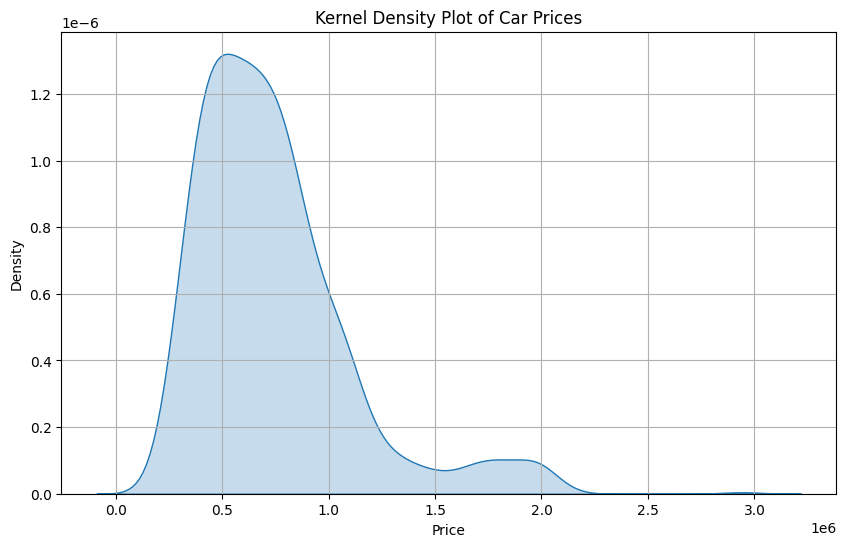

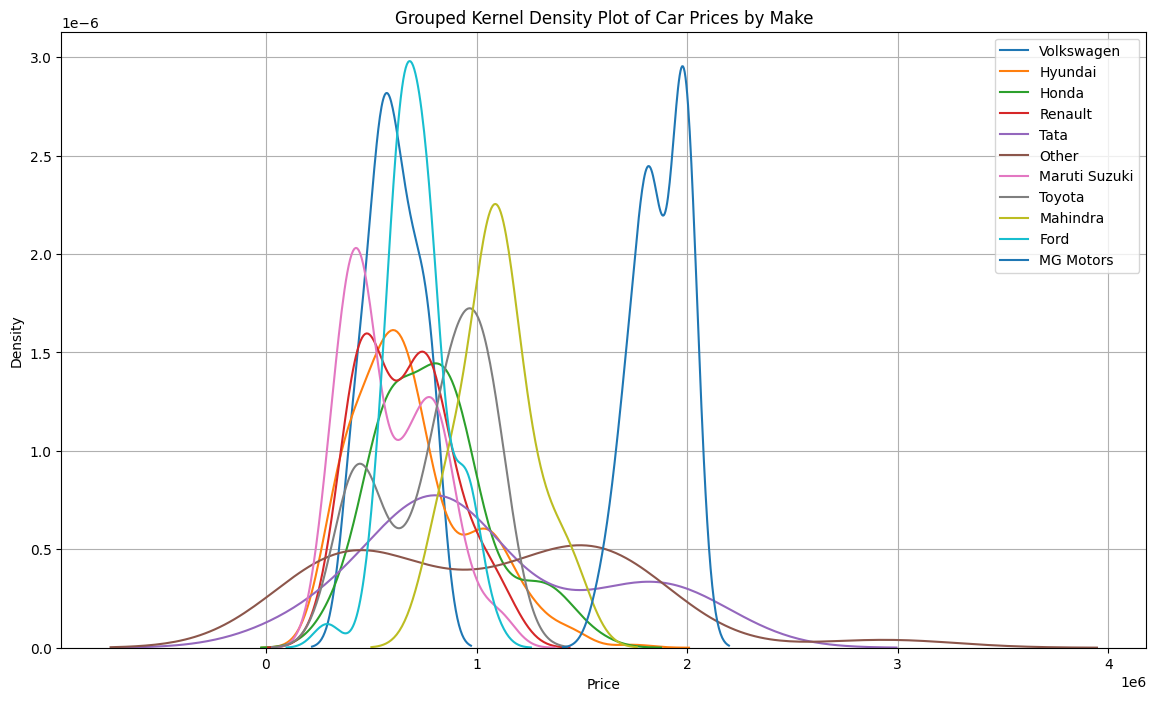

(count    9.760000e+02
 mean     7.410195e+05
 std      3.673234e+05
 min      1.880000e+05
 25%      4.757500e+05
 50%      6.665000e+05
 75%      8.830000e+05
 max      2.941000e+06
 Name: Price, dtype: float64,
                count          mean            std        min        25%  \
 Make                                                                      
 Ford            52.0  7.211731e+05  140927.699605   290000.0   635000.0   
 Honda           73.0  7.989726e+05  266509.066586   316000.0   581000.0   
 Hyundai        305.0  6.918918e+05  279159.708519   248000.0   485000.0   
 MG Motors       35.0  1.869457e+06  121661.135671  1589000.0  1786500.0   
 Mahindra        18.0  1.100167e+06  175549.305961   796000.0  1037000.0   
 Maruti Suzuki  293.0  5.887850e+05  216019.860943   237000.0   411000.0   
 Other           30.0  1.057433e+06  661244.369422   267000.0   443500.0   
 Renault         68.0  6.625735e+05  214827.338943   287000.0   475000.0   
 Tata            23.0  1.0

In [4]:
# 2

import seaborn as sns
import matplotlib.pyplot as plt

# summary statistics for the 'Price' variable
price_summary = cars_data_cleaned['Price'].describe()

# create a kernel density plot for the 'Price' variable
plt.figure(figsize=(10, 6))
sns.kdeplot(cars_data_cleaned['Price'], shade=True)
plt.title('Kernel Density Plot of Car Prices')
plt.xlabel('Price')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# grouped summary statistics for prices by 'Make'
grouped_price_summary = cars_data_cleaned.groupby('Make')['Price'].describe()

# grouped kernel density plots by 'Make'
plt.figure(figsize=(14, 8))
for make in cars_data_cleaned['Make'].unique():
    sns.kdeplot(cars_data_cleaned[cars_data_cleaned['Make'] == make]['Price'], label=make)
plt.title('Grouped Kernel Density Plot of Car Prices by Make')
plt.xlabel('Price')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

price_summary, grouped_price_summary


2.
The Price variable has a right-skewed distribution, which is common for price data, as there are often a few high-value items that can skew the distribution.

MG Motors has higher average prices compared to others. Tata and Other seem to have fairly evenly distributed prices. Many of the other cars have a somewhat lower average price.

In [5]:
# 3

# One-hot encode categorical variables with more than two categories
# For binary categorical variables, we'll use label encoding
categorical_columns = cars_data_cleaned.select_dtypes(include=['object']).columns.tolist()
binary_categorical_columns = [col for col in categorical_columns if len(cars_data_cleaned[col].unique()) == 2]
multi_categorical_columns = [col for col in categorical_columns if len(cars_data_cleaned[col].unique()) > 2]

# One-hot encoding for multi-categorical columns
cars_data_encoded = pd.get_dummies(cars_data_cleaned, columns=multi_categorical_columns, drop_first=True)

# Label encoding for binary categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in binary_categorical_columns:
    cars_data_encoded[col] = label_encoder.fit_transform(cars_data_encoded[col])

# Check the encoding and the new dataframe
cars_data_encoded.head()


,Make_Year,Mileage_Run,Seating_Capacity,Transmission_Type,Price,Make_Honda,Make_Hyundai,Make_MG Motors,Make_Mahindra,Make_Maruti Suzuki,...,Body_Type_sedan,Body_Type_suv,No_of_Owners_2nd,No_of_Owners_3rd,Fuel_Type_petrol,Fuel_Type_petrol+cng,Transmission_5-Speed,Transmission_6-Speed,Transmission_7-Speed,Transmission_CVT
0,2017,44611,5,0,657000,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,2016,20305,5,1,682000,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,2019,29540,5,1,793000,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,0
3,2017,35680,5,1,414000,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
4,2017,25126,5,1,515000,0,1,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [6]:
# 4

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into features and target variable
X = cars_data_encoded.drop('Price', axis=1)
y = cars_data_encoded['Price']

# Split the data into an 80% training set and a 20% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train and evaluate a model
def train_evaluate_model(X_train, X_test, y_train, y_test):
    # Initialize the linear regression model
    model = LinearRegression()
    # Fit the model on the training data
    model.fit(X_train, y_train)
    # Predict on the testing data
    y_pred = model.predict(X_test)
    # Calculate R^2 and RMSE
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return r2, rmse

# Model 1: Numeric variables only
numeric_columns = cars_data_encoded.select_dtypes(include=['int64', 'float64']).drop('Price', axis=1).columns.tolist()
r2_numeric, rmse_numeric = train_evaluate_model(X_train[numeric_columns], X_test[numeric_columns], y_train, y_test)

# Model 2: One-hot encoded categorical variables only
categorical_encoded_columns = list(set(X.columns) - set(numeric_columns))
r2_categorical, rmse_categorical = train_evaluate_model(X_train[categorical_encoded_columns], X_test[categorical_encoded_columns], y_train, y_test)

# Model 3: Combined numeric and one-hot encoded categorical variables
r2_combined, rmse_combined = train_evaluate_model(X_train, X_test, y_train, y_test)

(r2_numeric, rmse_numeric), (r2_categorical, rmse_categorical), (r2_combined, rmse_combined)


((0.2940701236475042, 284546.95190721675),
 (0.6749174668808333, 193094.53129537604),
 (0.7923523654168898, 154325.1296977349))

4. 
The combined model performs the best on the test set, with the highest $R^2$ and the lowest RMSE, suggesting that including both numeric and categorical variables provides the most informative set of predictors for car prices in this dataset. Compared to the model with numeric variables only, the combined model's $R^2$ is significantly higher and the RMSE is significantly lower, indicating a much better fit and predictive accuracy.

In [7]:
# 5

import numpy as np
from sklearn.preprocessing import PolynomialFeatures

# Function to create polynomial features and evaluate the model
def create_evaluate_polynomial(degree, X_train_numeric, X_test_numeric, X_train_cat, X_test_cat, y_train, y_test):
    # Create polynomial features for numeric variables
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train_numeric)
    X_test_poly = poly.transform(X_test_numeric)
    
    # Combine polynomial features with categorical variables
    X_train_poly_cat = np.concatenate((X_train_poly, X_train_cat), axis=1)
    X_test_poly_cat = np.concatenate((X_test_poly, X_test_cat), axis=1)
    
    # Train and evaluate the model
    r2, rmse = train_evaluate_model(X_train_poly_cat, X_test_poly_cat, y_train, y_test)
    return r2, rmse, X_train_poly_cat.shape[1]  # Return the number of features for reference

# Extract numeric and categorical data for the polynomial features model
X_train_numeric = X_train[numeric_columns].values
X_test_numeric = X_test[numeric_columns].values
X_train_categorical = X_train[categorical_encoded_columns].values
X_test_categorical = X_test[categorical_encoded_columns].values

# Initialize variables to keep track of the best model
best_degree = 1
best_r2 = r2_combined
best_rmse = rmse_combined
best_num_features = X_train.shape[1]

# Dictionary to keep track of performance metrics for each degree
polynomial_metrics = {}

# Starting with degree 2, increase the degree until R^2 becomes negative
degree = 2
while True:
    r2, rmse, num_features = create_evaluate_polynomial(degree, X_train_numeric, X_test_numeric, X_train_categorical, X_test_categorical, y_train, y_test)
    polynomial_metrics[degree] = (r2, rmse)
    
    # Update the best model if the current one is better
    if r2 > best_r2:
        best_r2 = r2
        best_rmse = rmse
        best_degree = degree
        best_num_features = num_features
    
    # Break if R^2 becomes negative
    if r2 < 0:
        break
    
    degree += 1

best_degree, best_r2, best_rmse, best_num_features, polynomial_metrics

# Initialize variables to keep track of the best model
best_degree = 1
best_r2 = 0
best_rmse = float('inf')
best_num_features = 0

# Dictionary to keep track of performance metrics for each degree
polynomial_metrics = {}

# Starting with degree 2, increase the degree until R^2 becomes negative
degree = 2
while True:
    r2, rmse, num_features = create_evaluate_polynomial(degree, X_train_numeric, X_test_numeric, X_train_categorical, X_test_categorical, y_train, y_test)
    polynomial_metrics[degree] = (r2, rmse)
    
    # Update the best model if the current one is better
    if r2 > best_r2:
        best_r2 = r2
        best_rmse = rmse
        best_degree = degree
        best_num_features = num_features
    
    # Break if R^2 becomes negative or if the degree is excessively high (to prevent excessive computation)
    if r2 < 0 or degree > 10:
        break
    
    degree += 1

# Display results
best_degree, best_r2, best_rmse, best_num_features, polynomial_metrics


(2,
 0.7931236232682285,
 154038.26104174778,
 47,
 {2: (0.7931236232682285, 154038.26104174778),
  3: (0.7404257152671405, 172545.6399164883),
  4: (0.33240434801900753, 276713.21883108886),
  5: (0.3193881658585346, 279397.7501165261),
  6: (0.3019805926403135, 282948.1803812863),
  7: (0.2607266822662746, 291189.47429459984),
  8: (0.2822555233387761, 286918.1923887903),
  9: (-0.04486645976677939, 346181.25720528176)})

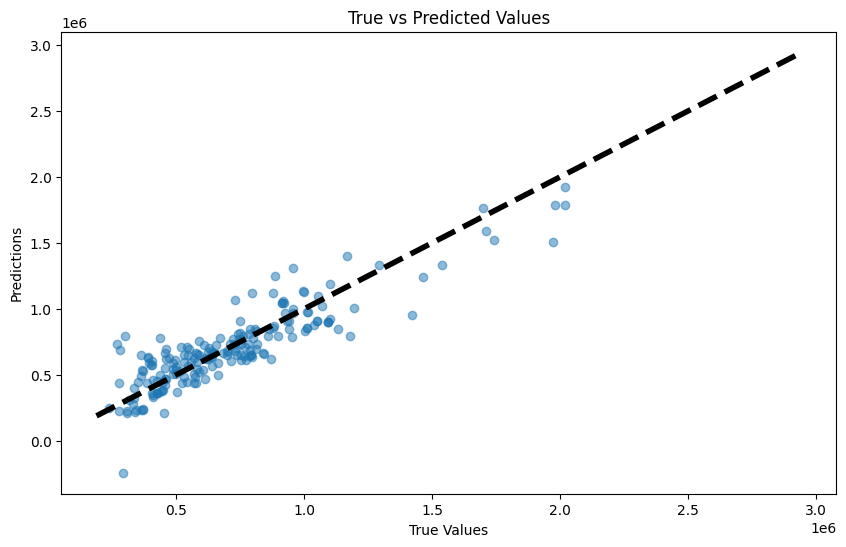

C:\Users\allard.ti\AppData\Local\Temp\ipykernel_19264\3512856773.py:31: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals, shade=True)


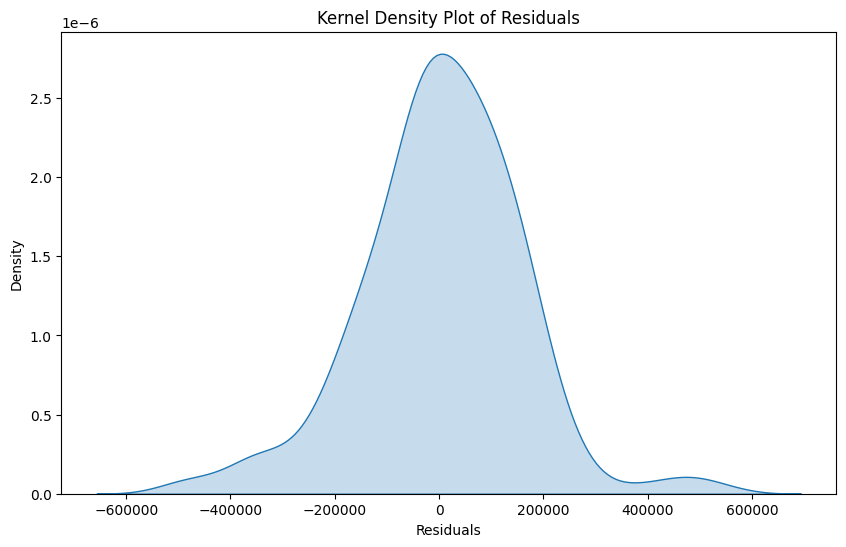

In [8]:
# 6

# Using the best model with polynomial degree 2 to predict the test data
poly = PolynomialFeatures(degree=best_degree)
X_train_poly = poly.fit_transform(X_train_numeric)
X_test_poly = poly.transform(X_test_numeric)
X_train_poly_cat = np.concatenate((X_train_poly, X_train_categorical), axis=1)
X_test_poly_cat = np.concatenate((X_test_poly, X_test_categorical), axis=1)

# Train the best model
best_poly_model = LinearRegression()
best_poly_model.fit(X_train_poly_cat, y_train)

# Predict on the test data
y_pred_best = best_poly_model.predict(X_test_poly_cat)

# Plot predicted vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.show()

# Compute residuals
residuals = y_test - y_pred_best

# Kernel density plot of residuals
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals, shade=True)
plt.title('Kernel Density Plot of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


6. 

The scatter plot of the predicted versus true values shows that the predicted values generally align along the diagonal, indicating a good predictive performance of the model. However, there are deviations, especially for higher values, which suggest the model's predictions are less accurate in that range.

The kernel density plot of the residuals shows that they are roughly centered around zero and have a bell-shaped distribution, which is a desirable property indicating that the model's errors are normally distributed, a common assumption in regression analysis.

Strengths of the Model:

- The model explains a significant portion of the variance in the data ($R^2≈0.822$).
- The residuals are generally well-behaved and normally distributed, suggesting the model's errors are random.

Weaknesses of the Model:

- There are areas, particularly at the higher price ranges, where the model does not predict as accurately, indicating potential limitations in capturing more complex relationships or outliers.
- The model could be susceptible to overfitting, especially if we had continued to increase the complexity with higher-degree polynomials.

In [9]:
# 7
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Function to train and evaluate a decision tree at a given depth
def train_evaluate_tree(max_depth, X_train, X_test, y_train, y_test):
    # Initialize the decision tree regressor model with a given max_depth
    tree_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    # Fit the model on the training data
    tree_model.fit(X_train, y_train)
    # Predict on the testing data
    y_pred = tree_model.predict(X_test)
    # Calculate R^2 and RMSE
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return r2, rmse

# Dictionary to keep track of performance metrics for each tree depth
tree_metrics = {}

# Try a range of depths from 1 to 15
for depth in range(1, 16):
    r2, rmse = train_evaluate_tree(depth, X_train, X_test, y_train, y_test)
    tree_metrics[depth] = (r2, rmse)

# Find the depth that gives the best R^2
best_tree_depth = max(tree_metrics, key=lambda k: tree_metrics[k][0])
best_tree_r2 = tree_metrics[best_tree_depth][0]
best_tree_rmse = tree_metrics[best_tree_depth][1]

best_tree_depth, best_tree_r2, best_tree_rmse, tree_metrics


(12,
 0.8295173438592588,
 139834.15361956425,
 {1: (0.2965014008678214, 284056.5283981426),
  2: (0.5468832455279129, 227970.27179370928),
  3: (0.7242294047388931, 177847.24205432727),
  4: (0.7400935124598451, 172656.01644741316),
  5: (0.7569713143177695, 166955.959421682),
  6: (0.7719474880261512, 161730.00004837997),
  7: (0.803577620611458, 150095.83470082586),
  8: (0.8242944289899907, 141959.97766952825),
  9: (0.8094598350716276, 147831.30983779376),
  10: (0.8256632239504027, 141405.94280788934),
  11: (0.8247198977778682, 141787.99636070163),
  12: (0.8295173438592588, 139834.15361956425),
  13: (0.8092552912854593, 147910.63659055153),
  14: (0.8011145838542659, 151033.96566345374),
  15: (0.8071399764141636, 148728.5227406145)})

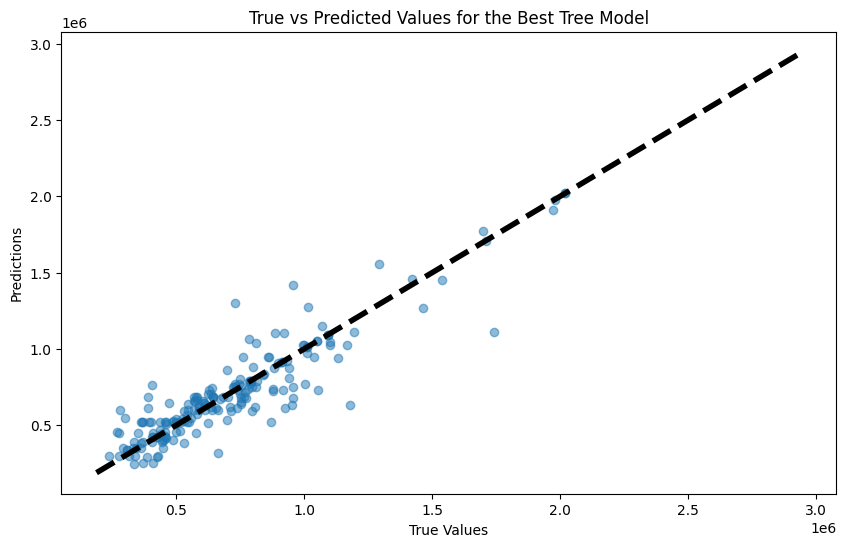

C:\Users\allard.ti\AppData\Local\Temp\ipykernel_19264\3411704153.py:24: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(residuals_tree, shade=True)


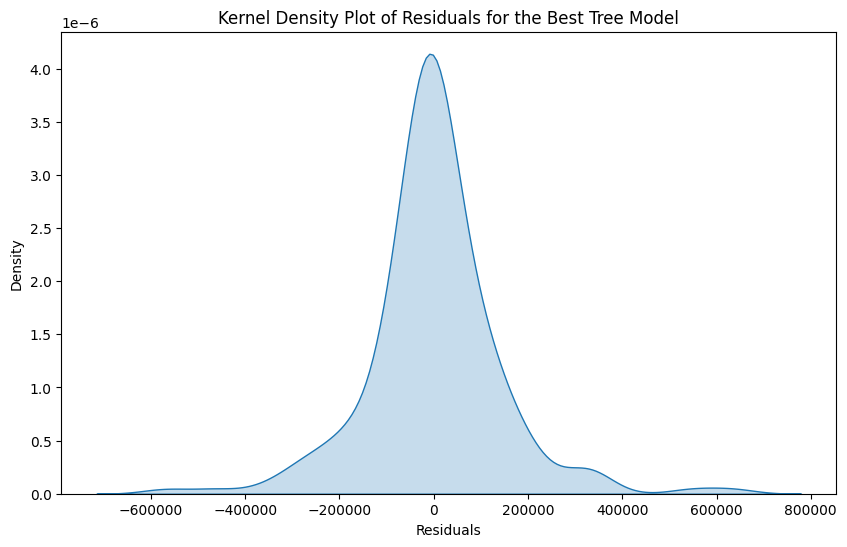

In [10]:
# 8

# Train the best tree model
best_tree_model = DecisionTreeRegressor(max_depth=best_tree_depth, random_state=42)
best_tree_model.fit(X_train, y_train)

# Predict on the test data using the best tree model
y_pred_tree = best_tree_model.predict(X_test)

# Plot predicted vs true values for the best tree model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tree, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values for the Best Tree Model')
plt.show()

# Compute residuals for the best tree model
residuals_tree = y_test - y_pred_tree

# Kernel density plot of residuals for the best tree model
plt.figure(figsize=(10, 6))
sns.kdeplot(residuals_tree, shade=True)
plt.title('Kernel Density Plot of Residuals for the Best Tree Model')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


8. 
The kernel density plot of the residuals for the best tree model shows that the residuals are centered around zero and appear to have a roughly bell-shaped distribution, which suggests that the model errors are normally distributed and the model does not systematically over- or under-predict across the range of values.

9. 

The regression tree outperforms the linear model.

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set? 
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4? 
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high 
    - Husband's education (categorical) 1=low, 2, 3, 4=high 
    - Number of children ever born (numerical) 
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent 
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where 
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

# 1.

To find the values of \( a \) and \( b \) that minimize the SSE, we take the partial derivatives of the SSE with respect to \( a \) and \( b \).

Given the SSE function:

$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2
$$

The partial derivative of SSE with respect to \( a \) is:

$$
\frac{\partial}{\partial a} \text{SSE}(a,b) = \frac{\partial}{\partial a} \sum_{i=1}^N (y_i - a - bz_i)^2 
$$

$$
= \frac{\partial}{\partial a} \sum_{i=1}^{N}(\left(y_{i}\right)^{2}-2 a \cdot y_{i}-b y_{i} z_{i}+a^{2} +a b z_{i}-b y_{i} z_{i}+a b z_{i}+b^{2} z_{i}^{2})
$$

$$
= \sum_{i=1}^N -2(y_i - a - bz_i)
$$

The partial derivative of SSE with respect to \( b \) is:

$$
\frac{\partial}{\partial b} \text{SSE}(a,b) = \frac{\partial}{\partial b} \sum_{i=1}^N (y_i - a - bz_i)^2
$$

$$
= \frac{\partial}{\partial b} \sum_{i=1}^N (-y_{i} z_{i}+a z_{i}- y_{i} z_{i}+ a z_{i}+  2 b z_{i}^{2})
$$

$$
= \sum_{i=1}^N -2(y_i - a - bz_i)z_i
$$

Setting these partial derivatives equal to zero for minimization gives us:

$$
\sum_{i=1}^N -2(y_i - a - bz_i) = 0
$$

$$
\sum_{i=1}^N -2(y_i - a - bz_i)z_i = 0
$$




# 2. 

Given that $\bar{z} = 0$, we solve for $a^*$ and $b^*$ using the following equations:

$$
\sum_{i=1}^N -2(y_i - a - bz_i) = 0
$$

$$
\sum_{i=1}^N -2(y_i - a - bz_i)z_i = 0
$$

For the first equation, we can use the fact that $\bar{z} = 0$ to simplify the equation:

$$
\sum_{i=1}^{N}-2\left(y_{i}-a-b z_{i}\right)=0
$$

$$
\begin{aligned}
& \sum_{i=1}^{N}-2\left[y_{i}-a-b\left(x_{i}-\bar{x}\right)\right]=0 \\
& -2 \sum_{i=1}^{N}\left[y_{i}-a-b x_{i}+b \bar{x}\right]=0 \\
& \sum_{i=1}^{N} y_{i}-\sum_{i=1}^{N} a-b \sum_{i=1}^{N} x_{i}+b \sum_{i=1}^{N} \bar{x}=0 \\
\sum_{i=1}^{N} a & =\sum_{i=1}^{N} y_{i}-b \cdot N \bar{x}+b \bar{x} N \\
\end{aligned}
$$

$$
Na^* = N\bar{y}
$$

Which gives us:

$$
a^* = \bar{y}
$$

For the second equation, we substitute $a^*$ with $\bar{y}$ and use the fact that $\sum_{i=1}^N z_i = 0$:

$$
\sum_{i=1}^N y_i z_i - \bar{y}\sum_{i=1}^N z_i - b^*\sum_{i=1}^N z_i^2 = 0
$$


$$
\sum_{i=1}^N y_i z_i = b^*\sum_{i=1}^N z_i^2
$$

Solving for $b^*$, we find:

$$
b^* = \frac{\sum_{i=1}^N (y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}
$$

So the solutions to the equations are:

$$
a^* = \bar{y}
$$
$$
b^* = \frac{\sum_{i=1}^N (y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}
$$


# 3. 

After finding the values for $a^*$ and $b^*$, we now substitute $z_i$ back with its definition $z_i = x_i - \bar{x}$ .


$$
a^* = \bar{y}
$$

$$
b^* = \frac{\sum_{i=1}^N (y_i - \bar{y})(x_i - \bar{x})}{\sum_{i=1}^N (x_i - \bar{x})^2}
$$

The numerator is the sample covariance between $x$ and $y$, and the denominator is the sample variance of $x$:

$$
a^* = \bar{y}
$$

$$
b^* = \frac{\text{cov}(x,y)}{\text{var}(x)}
$$


# 4.

When there is more noise/variance in $x$, the denominator gets larger, hence $b^{*}$ gets smaller assuming no changes to $\operatorname{cov}(x, y)$.

When $x, y$ are more correlated, $\operatorname{cov}(x, y)$ gets larger, assuming no changes to variance in $x, b^{*}$ gets larger. When $x, y$ are less correlated, the opposite happens when $b^{*}$ gets smaller.

$a^{*}$ represents the average value of $y$ values. It is the intercept of the regression line.

# 5

With artificially inflated variance in $x, b^{*}$ will get smaller due to an increased denominator, with $\operatorname{cov}(x, y)$ unchanged. The slope of the regression line is flatter than it truly is.

# 6

If a single value of $y_{i}$ is increased, $\operatorname{cov}(x, y)$ in the numerator will increase, therefore $b^{*}$ will increase in absolute terms.

If a single value of $x_{i}$ is increased, it will increase the variance of $x$ in the denominator and will potentially increase the numerator of $\operatorname{cov}(x, y)$. Therefore, $b^{*}$ could increase as a result.

If values of extreme observations are having huge influence over the coefficients, the model is less likely to perform well for average observations as it will overfit the outliers.